<a href="https://colab.research.google.com/github/volk401/Deep-learning/blob/main/notebooks/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Лабораторная работа №5

# Задание



Для набора данных с помощью автоэнкодера получить эмбеддинг изображений и его визуализировать.

Загрузить собственную аудиозапись и использовать автоэнкодер для удаления шума из аудиозаписи.

Отчет должен содержать: титульный лист, задание с вариантом, скриншоты и краткие пояснения по каждому этапу лабораторной работы, результаты эмбеддинга изображения, результаты удаления шума из аудиозаписи.

# Задания для самостоятельной работы
1. Проведите обучение модели по вашему варианту.
2. Измените гиперпараметры обучения для понижения ошибки модели: количество эпох, размер батча, скорость обучения, количество слоев и нейронов в них
3. Обучите модель автоэнкодера для удаления шума из аудио.
4. Измените гиперпараметры обучения для улучшения коэффициента детерминации: количество эпох, размер батча, скорость обучения, количество и конфигурацию сверточных слоев
5. Укажите, какие действия помогли улучшить метрики ваших моделей и объясните почему.

# Контрольные вопросы
1. Архитектура автоэнкодера. Варианты, применение
2. Что такое эмбеддинг. Что такое Метод главных компонент? Где применяется?
3. Форматы аудиофайлов, отличия. Формат представления аудио для нейросети.
4. Что такое коэффициент детерминации? Практический смысл, применение.
5. Функция потерь mse и оптимизатор adam.
6. Как работает транспонированный сверточный слой?
7. Функции активации: гиперболический тангенс и ELU.
8. Как устроен GAN?
9. Как устроен VAE?

## Часть 1. Автоэнкодер для визуализации данных

In [1]:
import pickle
from scipy import signal
from scipy.io import wavfile
import numpy as np
from IPython.display import display, Audio
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import r2_score
from IPython.display import clear_output
from ipywidgets import interact
from PIL import Image
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

--2023-04-20 18:46:05--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  30.6MB/s    in 5.9s    

2023-04-20 18:46:12 (27.4 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


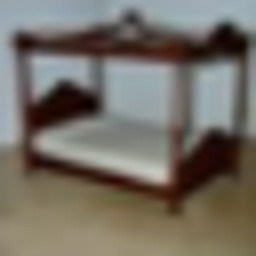

In [4]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [5, 30, 55]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

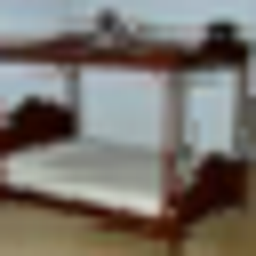

In [5]:
class CifarDataset(Dataset):
     def __init__(self, X, y, transform=None, p=0.0):
         assert X.size(0) == y.size(0)
         super(Dataset, self).__init__()
         self.X = X
         self.y = y
         self.transform = transform
         self.prob = p
        
     def __len__(self):
         return self.y.size(0)
        
     def __getitem__(self, index):
        x = self.X[index]
        if self.transform and np.random.random()<self.prob:
            x = self.transform(x.permute(2, 0, 1)/255.).permute(1, 2, 0)*255.
        y = self.y[index]
        return x, y

transform = T.Compose([
     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
     T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2),
                    shear=5),
])

Image.fromarray((transform(torch.Tensor(train_X[50]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))

In [32]:
batch_size = 128 #128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform if part=='train' else None,
                           p=0.5) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2, persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f67a417e130>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f67a075e1c0>}

In [45]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        #x = torch.mean(x, axis=-1)
        return torch.flatten(x, start_dim=1) # nhw -> nm

class Cifar100_AE(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_AE, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.encoder = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ELU(),
            nn.Linear(hidden_size//2, hidden_size//8),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size//8, hidden_size//2),
            nn.ELU(),
            nn.Linear(hidden_size//2, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, 32*32*3),
        )

    def forward(self, input):
        normed = self.norm(input)
        encoded = self.encoder(normed)
        out = self.decoder(encoded)
        return out, encoded, normed

HIDDEN_SIZE = 1024 #512
model = Cifar100_AE(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model.to(device)

Cifar100_AE(
  (norm): Normalize()
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=1024, out_features=3072, bias=True)
  )
)

In [46]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) #1e-3

  0%|          | 0/2400 [00:00<?, ?it/s]

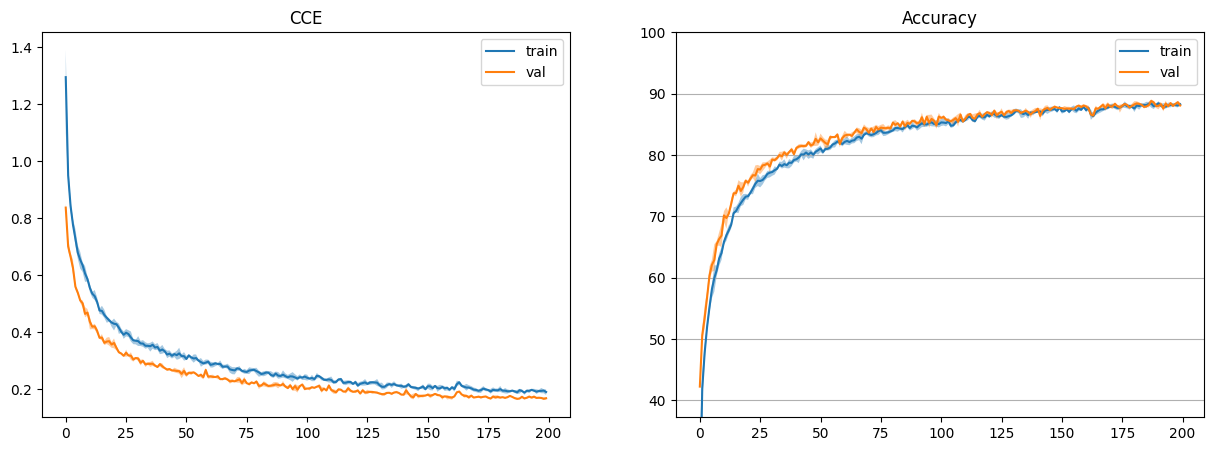

Обучение закончено за 182.1853733062744 секунд


In [47]:
EPOCHS = 200 #200
REDRAW_EVERY = 20
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    #running_loss = 0.0
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, _ = batch
        # на GPU
        inputs, _ = inputs.to(device), _.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs[0], outputs[2])
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = r2_score(outputs[2].detach().cpu().numpy(),
                            outputs[0].detach().cpu().numpy())*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    tmp = []
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, _ = data
            # на GPU
            inputs, _ = inputs.to(device), _.to(device)

            outputs = model(inputs)
            loss = criterion(outputs[0], outputs[2])
            accuracy = r2_score(outputs[2].detach().cpu().numpy(),
                            outputs[0].detach().cpu().numpy())*100
            tmp.append((loss.item(), accuracy.item()))
    #print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
print('Обучение закончено за %s секунд' % passed)

### Получение результатов обученной модели

In [48]:
print("train: ", end="")
print(losses[-1][0])
print("test: ", end="")
print(losses_val[-1][0])

train: [ 0.19075658 88.27010526]
test: [ 0.16868404 88.06703211]


In [ ]:
embeddings = []
colors = []
images = []
reconstructs = []
model.eval()
with torch.no_grad():
    for i, batch in enumerate(dataloader['test'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        out, embedding, norm = model(inputs)
        embeddings.append(embedding.detach().cpu().numpy())
        images.append(inputs.detach().cpu().numpy())
        reconstructs.append(out.detach().cpu().numpy())
        colors.append(labels.argmax(-1).detach().cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
images = np.concatenate(images, axis=0)
reconstructs = np.concatenate(reconstructs, axis=0)
reconstructs = (reconstructs-reconstructs.min())/(reconstructs.max()-reconstructs.min())
colors = np.concatenate(colors, axis=0)

### Визуализация восстановленной картинки

interactive(children=(IntSlider(value=0, description='index', max=300), Output()), _dom_classes=('widget-inter…

<function __main__.draw_comparision(index=0)>

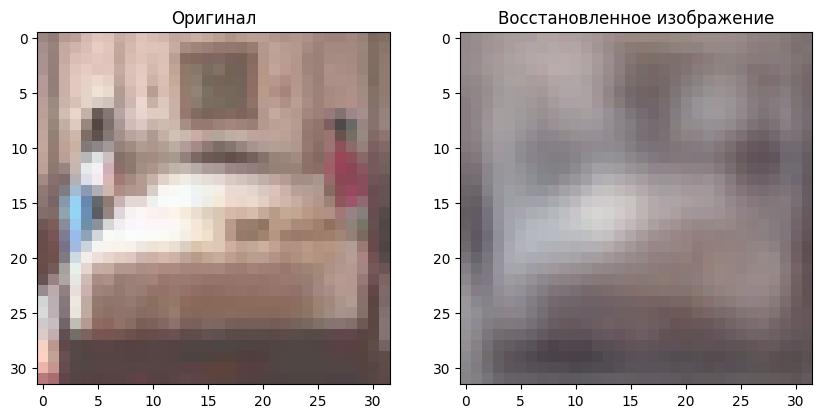

In [ ]:
def draw_comparision(index=0):
   fig, ax = plt.subplots(1, 2, figsize=(10, 5))
   ax[0].imshow(images[index].reshape(32,32,3)/255.)
   ax[1].imshow(reconstructs[index].reshape(32,32,3))
   ax[0].set_title('Оригинал')
   ax[1].set_title('Восстановленное изображение')

interact(draw_comparision, index=(0, len(images)))

### Визуализация эмбеддинга

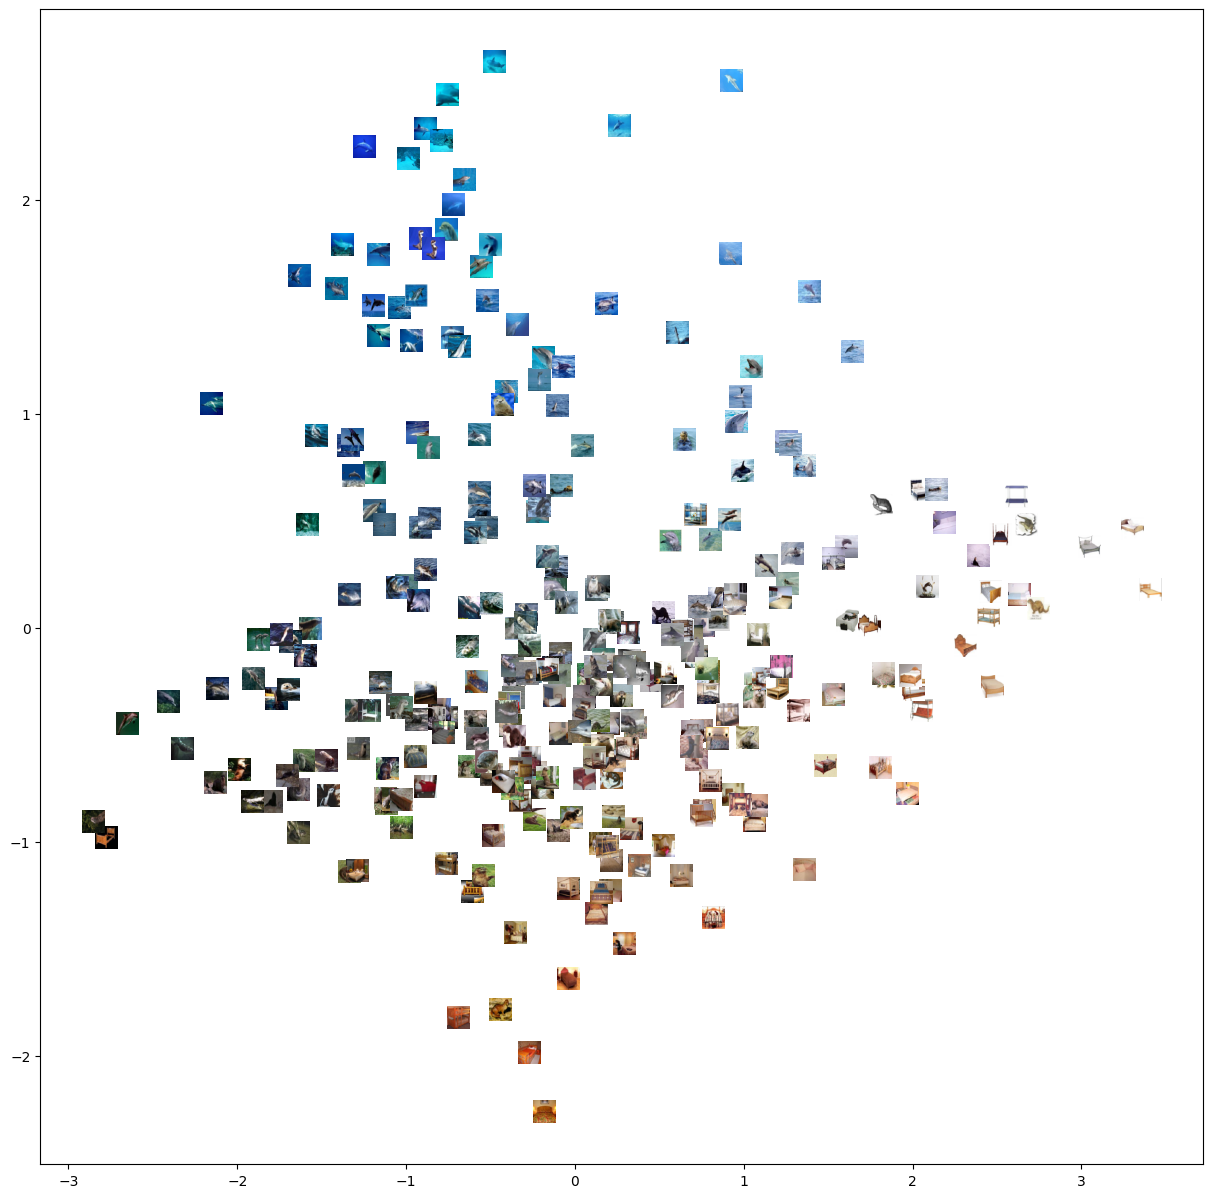

In [ ]:
# Тут мы применяем уменьшение размерности к многомерному
# эмбеддингу, полученному из бутылочного горлышка автоэнкодера.
# Можете попробовать сделать число нейронов равное 2
# и тогда данный этап можно пропустить и написать просто:
# projection = embeddings
projections = PCA(n_components=2).fit_transform(embeddings)

def implot(x, y, image, ax, zoom=1):
    im = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    ax.add_artist(ab)
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
for img, x in zip(images, projections):
    img = img.reshape(32, 32, 3)/255.
    implot(x[0], x[1], img, ax=ax, zoom=0.5)

## Часть 2. Очистка звука

In [49]:
# загрузка мелодии
!gdown --id 1Qta3KA-vYwMYN14FVdXXRvaRHwS_yJle
# загрузка шумов
!gdown --folder https://drive.google.com/drive/folders/1j5TXxdWw3Se9S-v-pniXafqeJaB_IUuM?usp=sharing
# конвертация в wav файл с одним каналом и частотой дискретизации 16кГц
!ffmpeg -y -i lacrimosa.mp4 -ac 1 -ar 16000 audio.wav
!ffmpeg -y -i noise_samples/pink.mp3 -ac 1 -ar 16000 noise.wav

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Qta3KA-vYwMYN14FVdXXRvaRHwS_yJle
To: /content/lacrimosa.mp4
100% 4.61M/4.61M [00:00<00:00, 157MB/s]
Retrieving folder list
Processing file 1BL_Dz0eIqD5KnQP1d3aDHFCHTK_jmQZ- bee.mp3
Processing file 1DC_r_wIcjjMNfzHZ-9kZvtv_aGJtLHSk bonfire.mp3
Processing file 18AZlP5iUDn7vb16SKbv7sBsW0Y09CrYJ cafe.mp3
Processing file 11cGrasUlxOOSkE_AfEsUVLgctHQBf1MW dolphin.mp3
Processing file 1xG28fXgvCFHJkXa0G4IJYMvvOFMjfYJj doroga.mp3
Processing file 1SRfXqrolb9YsQRD_6kR-B0RTYpurqCHy dyatel.mp3
Processing file 1ptA_oF2yrZgHJ_SoQT1nTTrhd-M2Yito forest.mp3
Processing file 1xmc2VO4EiYvaJZWO6WgMOmi1ZitiWu-z frog.mp3
Processing file 1vijIzwdH2WXLMg78XFoGXKnGWkoZmt9C grom.mp3
Processing file 1Ksad9YLozbdpzG651DSjNmGkLimzDkP9 heart.mp3
Process

In [50]:
# считывание аудио файла
fs, data = wavfile.read('audio.wav')
data = data / (2**16-1)
data[0] = 1
# добавление шума
#noise = np.random.normal(scale=0.25*data.std(), size=data.shape)
_, noise = wavfile.read('noise.wav')
noise = noise / (2**16-1) 
noise = np.tile(noise, 1+data.size//noise.size)[:data.size].copy()
noise = (0.1*data.max()/noise.max())*noise
data_noised = data+noise#np.clip(data + noise, -1, 1)

In [51]:
print('Original')
display(Audio(data[fs*10:fs*25], rate=fs))
print('Noised')
display(Audio(data_noised[fs*10:fs*25], rate=fs))

Original


Noised


In [52]:
_, _, Zxx = signal.stft(data_noised, fs=fs, nperseg=512)
_, xrec = signal.istft(Zxx, fs)
print('Reconstructed Noised')
display(Audio(xrec[fs*10:fs*25], rate=fs))
_, _, Zxx0 = signal.stft(noise, fs=fs, nperseg=512)
_, xrec = signal.istft(Zxx0, fs)
print('Noise')
display(Audio(xrec[fs*10:fs*25], rate=fs))

Reconstructed Noised


Noise


In [84]:
# https://github.com/digantamisra98/Mish
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        self.softplus = nn.Softplus()
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        return x*self.tanh(self.softplus(x))

class DenoisingAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(2, 256, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.Conv1d(512, 1024, kernel_size=3, stride=2, padding=1),
            Mish(),
            # nn.Conv1d(1024, 2048, kernel_size=3, stride=2, padding=1),
            # Mish(),
        )
        self.decoder = nn.Sequential(
            # nn.ConvTranspose1d(2048, 1024, kernel_size=3, stride=2, padding=1),
            # Mish(),
            nn.ConvTranspose1d(1024, 512, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.ConvTranspose1d(512, 256, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.ConvTranspose1d(256, 2, kernel_size=3, stride=2, padding=1),
        )
            

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = DenoisingAE()
net.to(device)
print(Zxx.shape[0])
net(torch.rand(1, 2, Zxx.shape[0], device=device)).detach().cpu().numpy().shape

257


(1, 2, 257)

In [85]:
criterion = nn.MSELoss()#nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)#, weight_decay=1e-6) #1e-4

In [86]:
batch_size = 128 #128

X = np.concatenate([np.real(Zxx).T[:,:,None],
                    np.imag(Zxx).T[:,:,None]], axis=-1)
y = np.concatenate([np.real(Zxx0).T[:,:,None],
                    np.imag(Zxx0).T[:,:,None]], axis=-1)

normalization = X.reshape(-1, 2).std()
X /= normalization
y /= normalization
tensor_x = torch.Tensor(np.transpose(X, [0, 2, 1])) # channels first
tensor_y = torch.Tensor(np.transpose(y, [0, 2, 1])) # channels first

train_dataset = TensorDataset(tensor_x[:tensor_x.shape[0]*9//10],
                              tensor_y[:tensor_x.shape[0]*9//10]) # create your datset
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size, shuffle=True) # create your dataloader
test_dataset = TensorDataset(tensor_x[tensor_x.shape[0]*9//10:],
                              tensor_y[tensor_x.shape[0]*9//10:]) # create your datset
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size, shuffle=True) # create your dataloader

In [87]:
def eval_dataset(dataloader):
    net.eval()
    target = []
    pred = []
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        preds = net(inputs).detach().cpu().numpy()
        target.append(inputs.detach().cpu().numpy().reshape(inputs.shape[0], -1))
        pred.append(preds.reshape(inputs.shape[0], -1))
    net.train()
    target = np.concatenate(target)
    pred = np.concatenate(pred)
    return r2_score(target, pred)

eval_dataset(train_dataloader)

-1.418877102359398

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[1,    96] loss: 0.11900
R2 score on train: 0.7432451804213897
R2 score on val: 0.7309105620797216


0it [00:00, ?it/s]

[2,    96] loss: 0.06231
R2 score on train: 0.803451105960675
R2 score on val: 0.7915203833235911


0it [00:00, ?it/s]

[3,    96] loss: 0.05752
R2 score on train: 0.8144345170552366
R2 score on val: 0.8044945425753551


0it [00:00, ?it/s]

[4,    96] loss: 0.05565
R2 score on train: 0.828118155237367
R2 score on val: 0.8207920113000613


0it [00:00, ?it/s]

[5,    96] loss: 0.05419
R2 score on train: 0.8316554156542423
R2 score on val: 0.8260548605362853


0it [00:00, ?it/s]

[6,    96] loss: 0.05332
R2 score on train: 0.8336292121628498
R2 score on val: 0.8289682709802666


0it [00:00, ?it/s]

[7,    96] loss: 0.05247
R2 score on train: 0.8300784038054538
R2 score on val: 0.8258900495122584


0it [00:00, ?it/s]

[8,    96] loss: 0.05191
R2 score on train: 0.8350521394524875
R2 score on val: 0.831879155813709


0it [00:00, ?it/s]

[9,    96] loss: 0.05120
R2 score on train: 0.8326684546510561
R2 score on val: 0.8296897851899949


0it [00:00, ?it/s]

[10,    96] loss: 0.05061
R2 score on train: 0.8370843311935182
R2 score on val: 0.8352021371046193


0it [00:00, ?it/s]

[11,    96] loss: 0.04977
R2 score on train: 0.8316618715143883
R2 score on val: 0.829288576470721


0it [00:00, ?it/s]

[12,    96] loss: 0.04893
R2 score on train: 0.8337187566749814
R2 score on val: 0.8329623448648508


0it [00:00, ?it/s]

[13,    96] loss: 0.04826
R2 score on train: 0.832385897611275
R2 score on val: 0.8315240902897313


0it [00:00, ?it/s]

[14,    96] loss: 0.04736
R2 score on train: 0.829631059005205
R2 score on val: 0.8289721644402818


0it [00:00, ?it/s]

[15,    96] loss: 0.04624
R2 score on train: 0.8334460069903779
R2 score on val: 0.8332924760428932
Finished Training


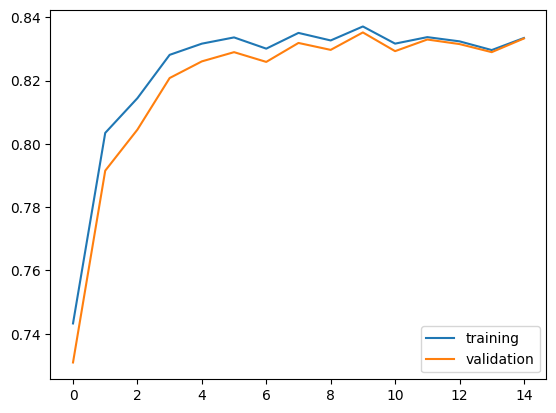

In [88]:
scores = []
scores_val = []
net.train()
for epoch in tqdm(range(15)):  # 15 loop over the dataset multiple times
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.5f}')
    scores.append(eval_dataset(train_dataloader))
    scores_val.append(eval_dataset(test_dataloader))
    print('R2 score on train:', scores[-1])
    print('R2 score on val:', scores_val[-1])
print('Finished Training')
plt.plot(scores, label='training')
plt.plot(scores_val, label='validation')
plt.legend()

In [58]:
net.eval()
pred = []
batch_size = 128
for i in tqdm(range(tensor_x.shape[0]//batch_size+1)):
    preds = net(tensor_x[i*batch_size:(i+1)*batch_size].to(device))
    pred.append(np.transpose(preds.detach().cpu().numpy(),
                             [0, 2, 1])*normalization)
pred = np.concatenate(pred, axis=0) 
_, xrec = signal.istft((pred[:,:,0]+pred[:,:,1]*1j).T, fs)
xrec = data_noised - xrec[:data.size]
print(r2_score(data, data_noised))
print(r2_score(data, xrec[:data.size]))
print('Original')
display(Audio(data[fs*50:fs*65], rate=fs))
print('Noised')
display(Audio(data_noised[fs*50:fs*65], rate=fs))
print('Denoised')
display(Audio(xrec[fs*50:fs*65], rate=fs))

  0%|          | 0/107 [00:00<?, ?it/s]

0.7591273691872571
0.9337175740630353
Original


Noised


Denoised


Теперь на базе предоставленного кода используйте свою мелодию/песню и шум по варианту

In [96]:
!ffmpeg -y -i Григ-Вальс.mp4 -ac 1 -ar 16000 audio2.wav

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [97]:
# считывание аудио файла
fs, data = wavfile.read('audio2.wav')
data = data / (2**16-1)
data[0] = 1
# добавление шума
#noise = np.random.normal(scale=0.25*data.std(), size=data.shape)
_, noise = wavfile.read('noise.wav')
noise = noise / (2**16-1) 
noise = np.tile(noise, 1+data.size//noise.size)[:data.size].copy()
noise = (0.1*data.max()/noise.max())*noise
data_noised = data+noise#np.clip(data + noise, -1, 1)

In [98]:
net.eval()
pred = []
batch_size = 128
for i in tqdm(range(tensor_x.shape[0]//batch_size+1)):
    preds = net(tensor_x[i*batch_size:(i+1)*batch_size].to(device))
    pred.append(np.transpose(preds.detach().cpu().numpy(),
                             [0, 2, 1])*normalization)
pred = np.concatenate(pred, axis=0) 
_, xrec = signal.istft((pred[:,:,0]+pred[:,:,1]*1j).T, fs)
xrec = data_noised - xrec[:data.size]
print(r2_score(data, data_noised))
print(r2_score(data, xrec[:data.size]))
print('Original')
display(Audio(data[fs*50:fs*65], rate=fs))
print('Noised')
display(Audio(data_noised[fs*50:fs*65], rate=fs))
print('Denoised')
display(Audio(xrec[fs*50:fs*65], rate=fs))

  0%|          | 0/107 [00:00<?, ?it/s]

0.8986282117735651
0.9776240307130655
Original


Noised


Denoised
